# Plotting Porod Results

This notebook plots the Porod fit results overlaid on the SANS data in this work. It also performs additional analyses with the fit parameters to extract more quantitative information about the interfaces within the conjugated polymer and polystyrene blends.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

from bumps.names import *
from bumps.fitters import fit

import sasmodels

from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data, empty_data1D
from sasmodels.direct_model import DirectModel

# uncomment following line to add path to sasview source code if necessary for your operating system/environment
# sys.path.append('/path/to/sasview/src')
import sas

# Loading Data and Meta-Data

In [3]:
# sample meta-data
sample_info = pd.read_csv('../../data/sans/Sample_Info.csv')

# helpful meta-data dictionaries
names = dict(zip(sample_info['Sample'], sample_info['Name']))
cps = dict(zip(sample_info['Sample'], sample_info['Conjugated Polymer']))
matrix = dict(zip(sample_info['Sample'], sample_info['Commodity Polymer']))
solvent_names = dict(zip(sample_info['Sample'], sample_info['Solvent']))

# target weight percents of conjugated polymer
target = dict(zip(sample_info['Sample'], sample_info['Target Fraction']*100))

# fixing 401/402 and 403/404 sample pair target values for plotting colors only
target[401] = 0.5
target[402] = 0.1
target[403] = 5
target[404] = 1

# actual volume polymer volume percentages determined by uv-vis 
data = np.loadtxt('../../data/uv_vis/Corrected_wtPercents.csv', delimiter=',', skiprows=1)
actual_wt = {}
actual_stdev_wt = {}
actual = {}
actual_stdev = {}
for key, tar, act, stdev, act_vol, stdev_vol in data:
    actual_wt[int(key)] = act
    actual_stdev_wt[int(key)] = stdev
    actual[int(key)] = act_vol
    actual_stdev[int(key)] = stdev_vol


In [4]:
# loading SANS and USANS data for each sample
data_dir = '../../data/sans/Smeared_Data_20200629/'
files = os.listdir(data_dir)
sans_data = {}
usans_data = {}
for file in files:
    if 'USANS' in file:
        key = int(file.split('_')[0][3:])
        usans_data[key] = load_data(data_dir + file)
    elif 'SANS' in file:
        key = int(file.split('_')[0][3:])
        sans_data[key] = load_data(data_dir + file)

In [5]:
# useful dictionaries with labels and colors for the plots and their legends
wt_names = {} 
full_names = {}

wt_colors = {}
solvent_colors = {}
cp_colors = {}

rep_colors = {}
rep_names = {}

temp_wt_colors = {
    0.1: 'firebrick',
    0.5: 'darkorange',
    1.0: 'darkcyan',
    5.0: 'mediumblue',
    10.0: 'deeppink',
    25.0: 'darkorchid',
    50.0: 'forestgreen',
    0.0: 'black'
}

temp_solvent_colors = {
    'Chloroform': 'firebrick',
    'Bromobenzene': 'darkorange',
    'Toluene': 'darkcyan',
    'Slow Dry Chloroform': 'forestgreen'
}

temp_cp_colors = {
    'RRe-P3HT': 'firebrick',
    'RRa-P3HT': 'darkorange',
    'P3DDT': 'forestgreen',
    'PQT-12': 'darkcyan',
    'None': 'black'
}

for key in names.keys():
    if key in actual_wt.keys():
        frac = actual_wt[key]
    else:
        frac = target[key]
    frac = np.round(frac,2)
    
    if cps[key] == 'None':
        wt_names[key] = matrix[key] + ' Control'
        full_names[key] = matrix[key] + ' Control'
    else:
        wt_names[key] = str(frac) + ' wt% ' + cps[key]
        full_names[key] = str(frac) + ' wt% ' + cps[key] + ' in ' + matrix[key]
        
for key in cps.keys():
    wt_colors[key] = temp_wt_colors[target[key]]
    solvent_colors[key] = temp_solvent_colors[solvent_names[key]]
    cp_colors[key] = temp_cp_colors[cps[key]]


## Loading Polystyrene Guinier-Porod Fits

In [6]:
# flat background for each sample
background_files = [file for file in os.listdir('../../data/sans/PS_Fitting/ps_fit_results/power_law_background') if 'json' in file]
backgrounds = {} # key is sample key, value is ('best', '95% confidence interval')
for file in background_files:
    data_read = pd.read_json('../../data/sans/PS_Fitting/ps_fit_results/power_law_background/' + file)
    key = int(file.split('_')[0][3:])
    p95 = data_read.loc['p95',str(key) + ' background']
    backgrounds[key] = (data_read.loc['best',str(key) + ' background'], p95)

# loading the polystyrene fit scales and also the polystyrene porod exponent
power_law_fit_info = pd.read_json('../../data/sans/PS_Fitting/ps_fit_results/power_law_porod_exp_scale/PS_porod_exp_scale-err.json')
ps_scales = {}
cp_scales = {} # will be set to zero for pure, polystyrene samples
for key, value in power_law_fit_info.items():
    if 'porod_exp' in key:
        ps_porod_exp = value['best']
        ps_porod_95p = value['p95']
    else:
        key = int(key.split()[0])
        ps_scales[key] = (value['best'], value['p95'])
        cp_scales[key] = (0, [0,0])

# loading radius of gyration and 's' dimensionality parameters from Guinier-Porod fit of polystyrene samples
guinier_porod_fit = pd.read_json('../../data/sans/PS_Fitting/ps_fit_results/guinier_porod_s_scale/PS_s_scale-err.json')
rgs = {}
for key, value in guinier_porod_fit.items():
    if key == 'ps s':
        ps_s = value['best']
        ps_s_95 = value['p95']
    elif 'rg' in key:
        key = int(key.split()[0])
        rgs[key] = (value['best'], value['p95'])
    elif 'scale' in key:
        key = int(key.split()[0])
        ps_scales[key] = (value['best'], value['p95'])
        

## Loading Porod Fits for Conjugated Polymer and Polystyrene-D8 Samples

In [7]:
# loads the polystyrene and conjugated polymer phase scales as well as the flat background
porod_files = [file for file in os.listdir('../../data/sans/Porod_analysis/porod_results') if 'json' in file]

for file in porod_files:
    data_read = pd.read_json('../../data/sans/Porod_analysis/porod_results/' + file)
    key = int(file.split('_')[0][3:])
    for column, value in data_read.items():
        if 'CP scale' in column:
            cp_scales[key] = (value['best'], value['p95'])
        elif 'PS scale' in column:
            ps_scales[key] = (value['best'], value['p95'])
        elif 'background' in column:
            backgrounds[key] = (value['best'], value['p95']) 

In [8]:
def plot_porod_fits(keys, sans_data_dict, usans_data_dict, zorders, label_dict, color_dict, filename, title=None, legend_title=None, size=6):

    """
    plot_porod_fits : function for uniformily plotting results of a Porod fit overlaid on the SANS data
    
    Parameters
    ----------
    
    keys :            sample keys to plot
    sans_data_dict :  dictionary of the SANS data, key is sample key, value is sasmodels data object
    usans_data_dict : dictionary of the USANS data, key is sample key, value is sasmodels data object
    zorders :         plot ordering tool, useful for designating which samples are plotted on top of 
                      others
    label_dict :      dictionary of the labels to use for each dataset, key is sample key, value is
                      the label (string)
    color_dict :      dictionary of the plotting colors for each sample, key is sample key, value is
                      the color (matplotlib-compatible string)
    filename :        path and name for saving the plot, single path string with filename included
    
    Optional Parameters
    -------------------
    
    title :           plot title, single string, default is None
    legend_title :    plot legend title, single string, default is None
    size :            data marker size, integer, default value is 6
    
    
    """
    
    # creating more extreme zorders to enforce plot ordering
    zorders = [(x*20, x*20+10) for x in zorders]
            
    # creating the figure        
    plt.figure(figsize=(6,6))
    
    i = 0 # tracking sample plotting to track zorders
    for key in keys:
        
        # Plotting Porod fits of samples with conjugated polymer and polystyrene-D8
        if target[key] > 0:
            
            # loading and plotting SANS data
            sans_data = sans_data_dict[key]
            plt.errorbar(sans_data.x, sans_data.y, yerr=sans_data.dy, zorder = zorders[i][0], label=label_dict[key], ms=size, color=color_dict[key], fmt='o', mec=color_dict[key], mfc='white',lw=1)
            
            # setting q-range for the Porod fit
            qmin = 2e-2
            if cps[key] == 'RRe-P3HT':
                if target[key] > 1:
                    qmin = 4e-2
                elif target[key] > 0.1:
                    qmin = 3e-2
            # creating q-data for the Porod fit
            porod_x = np.linspace(qmin,max(sans_data.x))
            
            # loading the dual Porod model (polystyrene + conjugated polymer) and applying parameters from fitting results
            kernel=load_model("power_law+power_law")

            sans_data.dx = sans_data.dx - sans_data.dx

            sans_model = Model(kernel, scale=1, background=backgrounds[key][0],  A_scale=ps_scales[key][0], B_scale=cp_scales[key][0], A_power=ps_porod_exp, B_power=4)
            sans_experiment = Experiment(data=sans_data, model=sans_model)
            sans_problem = FitProblem(sans_experiment)

            mask = np.where(sans_data.x >=qmin)
            
            # plotting the Porod fit
            plt.plot(sans_data.x[mask], sans_problem.fitness.theory()[mask], color=color_dict[key], zorder = zorders[i][1], linewidth=3, path_effects=[pe.Stroke(linewidth=5, foreground='white'), pe.Normal()])

            i+=1
        
        # plotting Guinier-Porod fit for polystyrene-D8 control samples
        else:
            
            # loading and plotting SANS data
            sans_data = sans_data_dict[key]
            plt.errorbar(sans_data.x, sans_data.y, yerr=sans_data.dy, zorder = zorders[i][0], label=label_dict[key], ms=size, fmt='o', color=color_dict[key], mec=color_dict[key], mfc='white')

            # setting q-range for the Porod fit
            qmin = 2e-2
            if cps[key] == 'RRe-P3HT':
                if target[key] > 1:
                    qmin = 4e-2
                elif target[key] > 0.1:
                    qmin = 3e-2
            porod_x = np.linspace(qmin,max(sans_data.x))
            
            # defining model based on whether the polystyrene sample was fit with a Guinier-Porod model (if USANS was available)
            # or the Porod model alone (if only SANS data was available)
            if key in rgs.keys():
                kernel=load_model("guinier_porod")
                sans_model=Model(kernel, scale=ps_scales[key][0], background=backgrounds[key][0], porod_exp=ps_porod_exp, s=ps_s, rg=rgs[key][0])
            else:
                kernel=load_model("power_law")
                sans_model = Model(kernel, scale=ps_scales[key][0], background=backgrounds[key][0], power=ps_porod_exp)

            sans_data.dx = sans_data.dx - sans_data.dx

            sans_experiment = Experiment(data=sans_data, model=sans_model)
            sans_problem = FitProblem(sans_experiment)

            mask = np.where(sans_data.x >= qmin)
            
            # plotting the Guinier-Porod or Porod fit
            plt.plot(sans_data.x[mask], sans_problem.fitness.theory()[mask], label='Porod Fit', color=color_dict[key], zorder = zorders[i][1], linewidth=3, path_effects=[pe.Stroke(linewidth=5, foreground='white'), pe.Normal()])
            
            i+=1
            
    # setting both axes to log scale
    plt.xscale('log')
    plt.yscale('log')

    # creating axis labels
    plt.xlabel(r'Q ($\AA^{-1}$)', fontsize=16)
    plt.ylabel(r'I(Q) (cm$^{-1}$)', fontsize=16)
    
    # creating plot legend
    legend = plt.legend(fontsize=12, title=legend_title)
    legend.get_title().set_fontsize('12')

    # updating x and y axis tick formatting
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # x and y axis limits
    plt.ylim(1e-02, 1e8)
    plt.xlim(0.0007, 0.3)

    # setting plot title
    if title is not None:
        plt.title(title, fontsize=16)
    
    # formatting and saving the figure
    plt.tight_layout()
    plt.savefig(filename, dpi=600)
    
    plt.close() # close figure to minimize active matplotlib plots in the notebook

## Creating Porod Fit Plots

In [24]:
# designated location for saving the plots
save_loc = '../../data/sans/Porod_analysis/porod_figures/fits/'
os.makedirs(save_loc, exist_ok=True)

# plots were created based on concentration series for blends of conjugated polymer and polystyrene

# CP + PS-D8 from August 2019 sample batch cast from chloroform
plot_porod_fits([1,2,3,4,5,21],sans_data,usans_data,[2,3,4,5,6,1],wt_names,wt_colors, save_loc + 'RReP3HT_CF_1.png',title='RRe-P3HT in PS-D8 from Chloroform')
plot_porod_fits([6,7,8,9,10,21],sans_data,usans_data,[2,3,4,5,6,1],wt_names,wt_colors, save_loc +'RRaP3HT_CF_1.png',title='RRa-P3HT in PS-D8 from Chloroform')
plot_porod_fits([11,12,13,14,15,21],sans_data,usans_data,[2,3,4,5,6,1],wt_names,wt_colors, save_loc +'P3DDT_CF.png',title='P3DDT in PS-D8 from Chloroform')
plot_porod_fits([16,17,18,19,20,21],sans_data,usans_data,[2,3,4,5,6,1],wt_names,wt_colors, save_loc +'PQT12_CF.png',title='PQT-12 in PS-D8 from Chloroform')

# RRe-P3HT and PS-D8 from December 2019 sample batch cast from chloroform
plot_porod_fits([101,102,103,104,105,106,107,113],sans_data,usans_data,[2,3,4,5,6,7,8,1],wt_names,wt_colors, save_loc +'RReP3HT_CF_2.png',title='RRe-P3HT in PS-D8 from Chloroform')
plot_porod_fits([108,109,110,111,112,114],sans_data,usans_data,[2,3,4,5,6,1],wt_names,wt_colors, save_loc +'RReP3HT_CF_3.png',title='RRe-P3HT in PS-D8 from Chloroform')

# CP and PS-D8 from August 2019 sample batch cast from bromobenzene
plot_porod_fits([22,23,24,28],sans_data,usans_data,[2,3,4,1],wt_names,wt_colors, save_loc +'RReP3HT_BB_1.png',title='RRe-P3HT in PS-D8 from Bromobenzene')
plot_porod_fits([25,26,27,28],sans_data,usans_data,[2,3,4,1],wt_names,wt_colors, save_loc +'P3DDT_BB.png',title='P3DDT in PS-D8 from Bromobenzene')

# CP and PS-D8 from August 2019 sample batch cast from toluene
plot_porod_fits([29,30,31,35],sans_data,usans_data,[2,3,4,1],wt_names,wt_colors, save_loc +'RReP3HT_Tol_1.png',title='RRe-P3HT in PS-D8 from Toluene')
plot_porod_fits([32,33,34,35],sans_data,usans_data,[2,3,4,1],wt_names,wt_colors, save_loc +'P3DDT_Tol.png',title='P3DDT in PS-D8 from Toluene')

# RRa-P3HT and PS-D8 from December 2019 sample batch cast from chloroform
plot_porod_fits([203,113],sans_data,usans_data,[2,1],wt_names,wt_colors, save_loc +'RRaP3HT_CF_2.png',title='RRa-P3HT in PS-D8 from Chloroform')
plot_porod_fits([205,206,114],sans_data,usans_data,[2,3,1],wt_names,wt_colors, save_loc +'RRaP3HT_CF_3.png',title='RRa-P3HT in PS-D8 from Chloroform')

# RRe-P3HT and PS-D8 from December 2019 sample batch cast from bromobenzene
plot_porod_fits([301,302,303,304,305,310],sans_data,usans_data,[2,3,4,5,6,1],wt_names,wt_colors, save_loc +'RReP3HT_BB_2.png',title='RRe-P3HT in PS-D8 from Bromobenzene')
plot_porod_fits([306,307,309],sans_data,usans_data,[2,3,1],wt_names,wt_colors, save_loc +'RReP3HT_BB_3.png',title='RRe-P3HT in PS-D8 from Bromobenzene')

# RRe-P3HT and PS-D8 from December 2019 sample batch cast from toluene
plot_porod_fits([402,401,404,403,405,409],sans_data,usans_data,[2,3,4,5,6,1],wt_names,wt_colors, save_loc +'RReP3HT_Tol_2.png',title='RRe-P3HT in PS-D8 from Toluene')
plot_porod_fits([406,407,408,409],sans_data,usans_data,[2,3,4,1],wt_names,wt_colors, save_loc +'RReP3HT_Tol_3.png',title='RRe-P3HT in PS-D8 from Toluene')

# RRe-P3HT and PS-D8 from December 2019 sample batch cast from chloroform - slow dry
plot_porod_fits([501,502,503,504,505,506],sans_data,usans_data,[2,3,4,5,6,1],wt_names,wt_colors, save_loc +'RReP3HT_CF_SLOW.png',title='RRe-P3HT in PS-D8 from Chloroform - Slow Dry')

## Surface Area : Volume Ratio Analysis

The interfacial concentration, S/V, was extracted from the conjugated polymer phase scale in the Porod fits, the contrast, or difference in SLD between conjugated polymer and polystyrene phases, and the known volume fraction of conjugated polymer in the blend as determined from UV-Vis experiments.

(1e-09, 10.0)

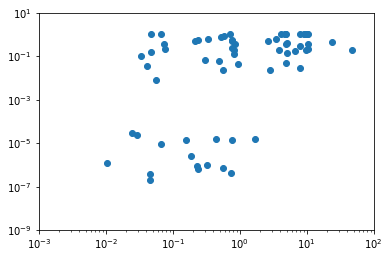

In [25]:
# will not utilize the fits with a very small scale of the conjugated polymer component
# this is indicating that we can not deconvolute the conjugated polymer from the 
# polystyrene contribution and this will result in outliers

wt_list = []
frac_list = []
for key in cp_scales.keys():
    if key in actual.keys():
        cp_val = cp_scales[key][0]
        ps_val = ps_scales[key][0]
        wt_list.append(actual_wt[key])
        frac_list.append(cp_val/(cp_val + ps_val))

# plotting the scales to find outlier samples with low amounts of conjugated polymer (bottom group in the plot)
plt.scatter(wt_list, frac_list)
plt.yscale('log')
plt.xscale('log')

plt.xlim(1e-3,1e2)
plt.ylim(1e-9,1e1)

In [26]:
# calculating the contrast for each sample, defined as the difference between scattering length density (SLD)
# of the conjugated polymer and polystyrene phases squared
slds = {'RRe-P3HT':0.676,
       'RRa-P3HT':0.676,
       'P3DDT':0.316,
       'PQT-12':0.676,
       'Polystyrene-D8':6.464, # assumed density of 1.13 g/mL
       'Polystyrene-H8':1.426}

contrast = {}
for key in actual.keys():
    sld_cp = slds[cps[key]]*10**(-6)
    sld_ps = slds[matrix[key]]*10**(-6)
    contrast[key] = (sld_cp - sld_ps)**2

# determining interfacial concentration, S/V, and a 95% confidence interval based on fitting results and uncertainty analysis
Sv = {}
Sv_95 = {}
for key in actual.keys():
    if key in cp_scales.keys():
        cp_scale = cp_scales[key][0]
        cp_95 = cp_scales[key][1]
        ps_scale = ps_scales[key][0]
        frac = cp_scale/(cp_scale+ps_scale)
        if frac > 1e-3: # removing outliers based on the above plot
            Sv[key] = cp_scale/(2*np.pi*contrast[key]*(actual[key]/100)*10**8)
            Sv_max = cp_95[1]/(2*np.pi*contrast[key]*(actual[key]/100)*10**8)
            Sv_min = cp_95[0]/(2*np.pi*contrast[key]*(actual[key]/100)*10**8)
            Sv_95[key] = (Sv_min, Sv_max)
            
min_sv = min(Sv.values())
max_sv = max(Sv.values())

print(min_sv, max_sv)


7.071268651712071e-05 0.015867571350904934


### Plot Interfacial Concentration for RRa-P3HT & PS-D8 Blends cast from Chloroform

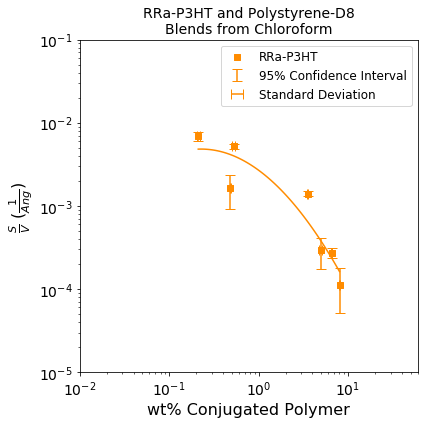

In [27]:
plt.figure(figsize=(6,6))

keys = [6,7,8,9,10,201,202,203,204,205,206]
conc = []
conc_stdev = []
sv_list = []
sv_middle = []
sv_size = []
for key in keys:
    if key in Sv.keys():
        conc.append(actual_wt[key])
        conc_stdev.append(actual_stdev_wt[key])
        sv_list.append(Sv[key])
        sv_max = Sv_95[key][1]
        sv_min = Sv_95[key][0]
        sv_middle.append((sv_max + sv_min)/2)
        sv_size.append((sv_max - sv_min)/2)
plt.scatter(conc, sv_list, label = 'RRa-P3HT', c='darkorange', marker='s')
plt.errorbar(conc, sv_middle, yerr=sv_size, capsize=5, c='darkorange', label='95% Confidence Interval', fmt='none')
plt.errorbar(conc, sv_list, xerr=conc_stdev, capsize=5, c='darkorange', label='Standard Deviation', fmt='none')

fit_params = np.polyfit(np.log(conc), np.log(sv_list), 2)
fit_function = np.poly1d(fit_params)
x_fit = np.linspace(min(np.log(conc)), max(np.log(conc)), 100)
y_fit = fit_function(x_fit)
plt.plot(np.exp(x_fit), np.exp(y_fit), c='darkorange', label=None)

plt.xscale('log')
plt.yscale('log')

plt.xlim(0.01, 60)
plt.ylim(1e-5,1e-1)
#plt.ylim(-0.005, max(Sv.values()))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.legend(fontsize = 12)

plt.xlabel(r'wt% Conjugated Polymer', fontsize=16)
plt.ylabel(r'$\frac{S}{V}$ ($\frac{1}{Ang}$)', fontsize=16)

plt.title('RRa-P3HT and Polystyrene-D8\nBlends from Chloroform', fontsize=14)

plt.tight_layout()

plt.savefig('../../data/sans/Porod_analysis/porod_figures/sv_plots/WithPSContribution_RRaP3HT_CF.png', dpi=300)


### Plot Interfacial Concentration for P3DDT & PS-D8 Blends cast from Chloroform

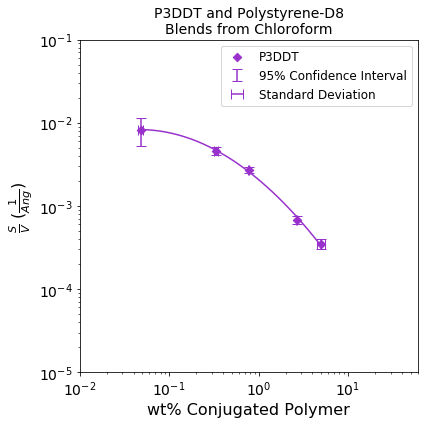

In [36]:
plt.figure(figsize=(6,6))

keys = [11,12,13,14,15]
conc = []
conc_stdev = []
sv_list = []
sv_middle = []
sv_size = []
for key in keys:
    if key in Sv.keys():
        conc.append(actual_wt[key])
        conc_stdev.append(actual_stdev_wt[key])
        sv_list.append(Sv[key])
        sv_max = Sv_95[key][1]
        sv_min = Sv_95[key][0]
        sv_middle.append((sv_max + sv_min)/2)
        sv_size.append((sv_max - sv_min)/2)
plt.scatter(conc, sv_list, label = 'P3DDT', c='darkorchid', marker='D')
plt.errorbar(conc, sv_middle, yerr=sv_size, capsize=5, c='darkorchid', label='95% Confidence Interval', fmt='none')
plt.errorbar(conc, sv_list, xerr=conc_stdev, capsize=5, c='darkorchid', label='Standard Deviation', fmt='none')

fit_params = np.polyfit(np.log(conc), np.log(sv_list), 2)
fit_function = np.poly1d(fit_params)
x_fit = np.linspace(min(np.log(conc)), max(np.log(conc)), 100)
y_fit = fit_function(x_fit)
plt.plot(np.exp(x_fit), np.exp(y_fit), c='darkorchid', label=None)

plt.xscale('log')
plt.yscale('log')

plt.xlim(0.01, 60)
plt.ylim(1e-5,1e-1)
#plt.ylim(-0.005, max(Sv.values()))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.legend(fontsize = 12)

plt.xlabel(r'wt% Conjugated Polymer', fontsize=16)
plt.ylabel(r'$\frac{S}{V}$ ($\frac{1}{Ang}$)', fontsize=16)

plt.title('P3DDT and Polystyrene-D8\nBlends from Chloroform', fontsize=14)

plt.tight_layout()

plt.savefig('../../data/sans/Porod_analysis/porod_figures/sv_plots/WithPSContribution_P3DDT_CF.png', dpi=300)


### Plot Interfacial Concentration for PQT-12 & PS-D8 Blends cast from Chloroform

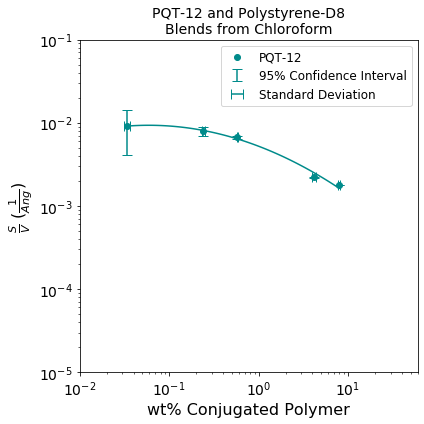

In [29]:
plt.figure(figsize=(6,6))

keys = [16,17,18,19,20]
conc = []
conc_stdev = []
sv_list = []
sv_middle = []
sv_size = []
for key in keys:
    if key in Sv.keys():
        conc.append(actual_wt[key])
        conc_stdev.append(actual_stdev_wt[key])
        sv_list.append(Sv[key])
        sv_max = Sv_95[key][1]
        sv_min = Sv_95[key][0]
        sv_middle.append((sv_max + sv_min)/2)
        sv_size.append((sv_max - sv_min)/2)
plt.scatter(conc, sv_list, label = 'PQT-12', c='darkcyan', marker='o')
plt.errorbar(conc, sv_middle, yerr=sv_size, capsize=5, c='darkcyan', label='95% Confidence Interval', fmt='none')
plt.errorbar(conc, sv_list, xerr=conc_stdev, capsize=5, c='darkcyan', label='Standard Deviation', fmt='none')

fit_params = np.polyfit(np.log(conc), np.log(sv_list), 2)
fit_function = np.poly1d(fit_params)
x_fit = np.linspace(min(np.log(conc)), max(np.log(conc)), 100)
y_fit = fit_function(x_fit)
plt.plot(np.exp(x_fit), np.exp(y_fit), c='darkcyan', label=None)

plt.xscale('log')
plt.yscale('log')

plt.xlim(0.01, 60)
plt.ylim(1e-5,1e-1)
#plt.ylim(-0.005, max(Sv.values()))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.legend(fontsize = 12)

plt.xlabel(r'wt% Conjugated Polymer', fontsize=16)
plt.ylabel(r'$\frac{S}{V}$ ($\frac{1}{Ang}$)', fontsize=16)

plt.title('PQT-12 and Polystyrene-D8\nBlends from Chloroform', fontsize=14)

plt.tight_layout()

plt.savefig('../../data/sans/Porod_analysis/porod_figures/sv_plots/WithPSContribution_PQT12_CF.png', dpi=300)


### Plot Interfacial Concentration for RRe-P3HT & PS-D8 Blends cast from Chloroform

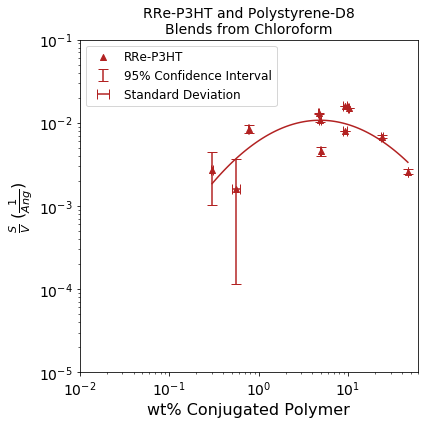

In [30]:
plt.figure(figsize=(6,6))

keys = [1,2,3,4,5,101,102,103,104,105,106,107,108,109,110,111,112,113,114]
conc = []
conc_stdev = []
sv_list = []
sv_middle = []
sv_size = []
for key in keys:
    if key in Sv.keys():
        conc.append(actual_wt[key])
        conc_stdev.append(actual_stdev_wt[key])
        sv_list.append(Sv[key])
        sv_max = Sv_95[key][1]
        sv_min = Sv_95[key][0]
        sv_middle.append((sv_max + sv_min)/2)
        sv_size.append((sv_max - sv_min)/2)
plt.scatter(conc, sv_list, label = 'RRe-P3HT', c='firebrick', marker='^')
plt.errorbar(conc, sv_middle, yerr=sv_size, capsize=5, c='firebrick', label='95% Confidence Interval', fmt='none')
plt.errorbar(conc, sv_list, xerr=conc_stdev, capsize=5, c='firebrick', label='Standard Deviation', fmt='none')

fit_params = np.polyfit(np.log(conc), np.log(sv_list), 2)
fit_function = np.poly1d(fit_params)
x_fit = np.linspace(min(np.log(conc)), max(np.log(conc)), 100)
y_fit = fit_function(x_fit)
plt.plot(np.exp(x_fit), np.exp(y_fit), c='firebrick', label=None)

plt.xscale('log')
plt.yscale('log')

plt.xlim(0.01, 60)
plt.ylim(1e-5,1e-1)
#plt.ylim(-0.005, max(Sv.values()))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.legend(fontsize = 12)

plt.xlabel(r'wt% Conjugated Polymer', fontsize=16)
plt.ylabel(r'$\frac{S}{V}$ ($\frac{1}{Ang}$)', fontsize=16)

plt.title('RRe-P3HT and Polystyrene-D8\nBlends from Chloroform', fontsize=14)

plt.tight_layout()

plt.savefig('../../data/sans/Porod_analysis/porod_figures/sv_plots/WithPSContribution_RReP3HT_CF.png', dpi=300)


### Plot Interfacial Concentration for RRe-P3HT & PS-D8 Blends cast from Bromobenzene

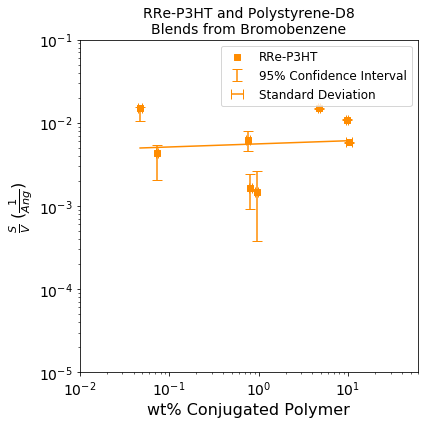

In [31]:
plt.figure(figsize=(6,6))

keys = [22,23,24,301,302,303,304,305,306,307,308,309,310]
conc = []
conc_stdev = []
sv_list = []
sv_middle = []
sv_size = []
for key in keys:
    if key in Sv.keys():
        conc.append(actual_wt[key])
        conc_stdev.append(actual_stdev_wt[key])
        sv_list.append(Sv[key])
        sv_max = Sv_95[key][1]
        sv_min = Sv_95[key][0]
        sv_middle.append((sv_max + sv_min)/2)
        sv_size.append((sv_max - sv_min)/2)
plt.scatter(conc, sv_list, label = 'RRe-P3HT', c='darkorange', marker='s')
plt.errorbar(conc, sv_middle, yerr=sv_size, capsize=5, c='darkorange', label='95% Confidence Interval', fmt='none')
plt.errorbar(conc, sv_list, xerr=conc_stdev, capsize=5, c='darkorange', label='Standard Deviation', fmt='none')

fit_params = np.polyfit(np.log(conc), np.log(sv_list), 1)
fit_function = np.poly1d(fit_params)
x_fit = np.linspace(min(np.log(conc)), max(np.log(conc)), 100)
y_fit = fit_function(x_fit)
plt.plot(np.exp(x_fit), np.exp(y_fit), c='darkorange', label=None)

plt.xscale('log')
plt.yscale('log')

plt.xlim(0.01, 60)
plt.ylim(1e-5,1e-1)
#plt.ylim(-0.005, max(Sv.values()))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.legend(fontsize = 12)

plt.xlabel(r'wt% Conjugated Polymer', fontsize=16)
plt.ylabel(r'$\frac{S}{V}$ ($\frac{1}{Ang}$)', fontsize=16)

plt.title('RRe-P3HT and Polystyrene-D8\nBlends from Bromobenzene', fontsize=14)

plt.tight_layout()

plt.savefig('../../data/sans/Porod_analysis/porod_figures/sv_plots/WithPSContribution_RReP3HT_BB.png', dpi=300)


### Plot Interfacial Concentration for RRe-P3HT & PS-D8 Blends cast from Toluene

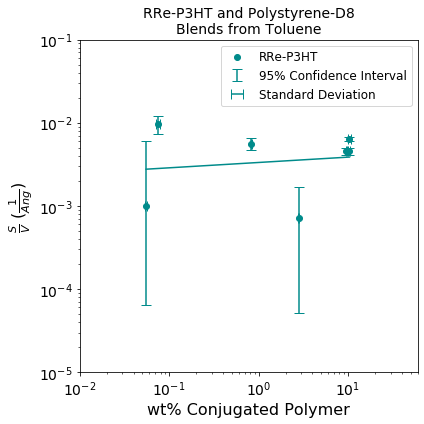

In [32]:
plt.figure(figsize=(6,6))

keys = [29,30,31,401,402,403,404,405,406,407,408,409,410]
conc = []
conc_stdev = []
sv_list = []
sv_middle = []
sv_size = []
for key in keys:
    if key in Sv.keys():
        conc.append(actual_wt[key])
        conc_stdev.append(actual_stdev_wt[key])
        sv_list.append(Sv[key])
        sv_max = Sv_95[key][1]
        sv_min = Sv_95[key][0]
        sv_middle.append((sv_max + sv_min)/2)
        sv_size.append((sv_max - sv_min)/2)
plt.scatter(conc, sv_list, label = 'RRe-P3HT', c='darkcyan', marker='o')
plt.errorbar(conc, sv_middle, yerr=sv_size, capsize=5, c='darkcyan', label='95% Confidence Interval', fmt='none')
plt.errorbar(conc, sv_list, xerr=conc_stdev, capsize=5, c='darkcyan', label='Standard Deviation', fmt='none')

fit_params = np.polyfit(np.log(conc), np.log(sv_list), 1)
fit_function = np.poly1d(fit_params)
x_fit = np.linspace(min(np.log(conc)), max(np.log(conc)), 100)
y_fit = fit_function(x_fit)
plt.plot(np.exp(x_fit), np.exp(y_fit), c='darkcyan', label=None)

plt.xscale('log')
plt.yscale('log')

plt.xlim(0.01, 60)
plt.ylim(1e-5,1e-1)
#plt.ylim(-0.005, max(Sv.values()))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.legend(fontsize = 12)

plt.xlabel(r'wt% Conjugated Polymer', fontsize=16)
plt.ylabel(r'$\frac{S}{V}$ ($\frac{1}{Ang}$)', fontsize=16)

plt.title('RRe-P3HT and Polystyrene-D8\nBlends from Toluene', fontsize=14)

plt.tight_layout()

plt.savefig('../../data/sans/Porod_analysis/porod_figures/sv_plots/WithPSContribution_RReP3HT_Tol.png', dpi=300)


### Plot Interfacial Concentration for P3DDT & PS-D8 Blends cast from Bromobenzene

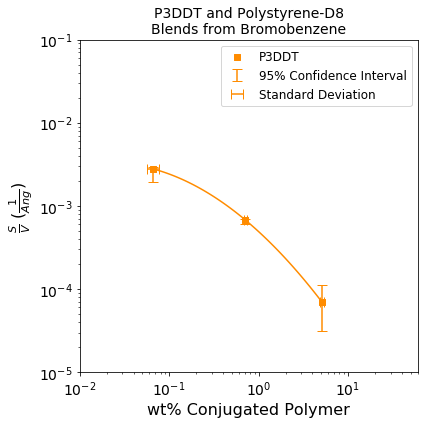

In [33]:
plt.figure(figsize=(6,6))

keys = [25,26,27]
conc = []
conc_stdev = []
sv_list = []
sv_middle = []
sv_size = []
for key in keys:
    if key in Sv.keys():
        conc.append(actual_wt[key])
        conc_stdev.append(actual_stdev_wt[key])
        sv_list.append(Sv[key])
        sv_max = Sv_95[key][1]
        sv_min = Sv_95[key][0]
        sv_middle.append((sv_max + sv_min)/2)
        sv_size.append((sv_max - sv_min)/2)
plt.scatter(conc, sv_list, label = 'P3DDT', c='darkorange', marker='s')
plt.errorbar(conc, sv_middle, yerr=sv_size, capsize=5, c='darkorange', label='95% Confidence Interval', fmt='none')
plt.errorbar(conc, sv_list, xerr=conc_stdev, capsize=5, c='darkorange', label='Standard Deviation', fmt='none')

fit_params = np.polyfit(np.log(conc), np.log(sv_list), 2)
fit_function = np.poly1d(fit_params)
x_fit = np.linspace(min(np.log(conc)), max(np.log(conc)), 100)
y_fit = fit_function(x_fit)
plt.plot(np.exp(x_fit), np.exp(y_fit), c='darkorange', label=None)

plt.xscale('log')
plt.yscale('log')

plt.xlim(0.01, 60)
plt.ylim(1e-5,1e-1)
#plt.ylim(-0.005, max(Sv.values()))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.legend(fontsize = 12)

plt.xlabel(r'wt% Conjugated Polymer', fontsize=16)
plt.ylabel(r'$\frac{S}{V}$ ($\frac{1}{Ang}$)', fontsize=16)

plt.title('P3DDT and Polystyrene-D8\nBlends from Bromobenzene', fontsize=14)

plt.tight_layout()

plt.savefig('../../data/sans/Porod_analysis/porod_figures/sv_plots/WithPSContribution_P3DDT_BB.png', dpi=300)


### Plot Interfacial Concentration for P3DDT & PS-D8 Blends cast from Toluene

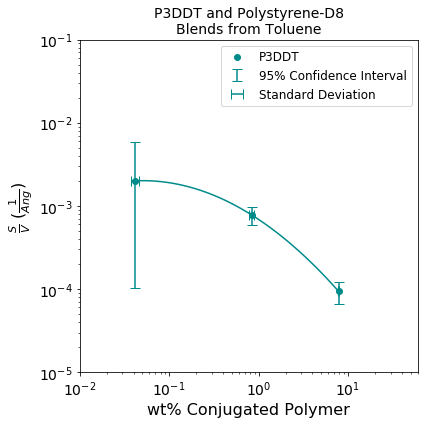

In [34]:
plt.figure(figsize=(6,6))

keys = [32,33,34]
conc = []
conc_stdev = []
sv_list = []
sv_middle = []
sv_size = []
for key in keys:
    if key in Sv.keys():
        conc.append(actual_wt[key])
        conc_stdev.append(actual_stdev_wt[key])
        sv_list.append(Sv[key])
        sv_max = Sv_95[key][1]
        sv_min = Sv_95[key][0]
        sv_middle.append((sv_max + sv_min)/2)
        sv_size.append((sv_max - sv_min)/2)
plt.scatter(conc, sv_list, label = 'P3DDT', c='darkcyan', marker='o')
plt.errorbar(conc, sv_middle, yerr=sv_size, capsize=5, c='darkcyan', label='95% Confidence Interval', fmt='none')
plt.errorbar(conc, sv_list, xerr=conc_stdev, capsize=5, c='darkcyan', label='Standard Deviation', fmt='none')

fit_params = np.polyfit(np.log(conc), np.log(sv_list), 2)
fit_function = np.poly1d(fit_params)
x_fit = np.linspace(min(np.log(conc)), max(np.log(conc)), 100)
y_fit = fit_function(x_fit)
plt.plot(np.exp(x_fit), np.exp(y_fit), c='darkcyan', label=None)

plt.xscale('log')
plt.yscale('log')

plt.xlim(0.01, 60)
plt.ylim(1e-5,1e-1)
#plt.ylim(-0.005, max(Sv.values()))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.legend(fontsize = 12)

plt.xlabel(r'wt% Conjugated Polymer', fontsize=16)
plt.ylabel(r'$\frac{S}{V}$ ($\frac{1}{Ang}$)', fontsize=16)

plt.title('P3DDT and Polystyrene-D8\nBlends from Toluene', fontsize=14)

plt.tight_layout()

plt.savefig('../../data/sans/Porod_analysis/porod_figures/sv_plots/WithPSContribution_P3DDT_Tol.png', dpi=300)
